# Scenario 2 modeling

Out objective in this Case is to create a model that is able to predict the Return on Investment (ROI) of a cohort at a horizon of H days after the cohort was approved. We wish to make this prediction using a specific number of days, which we will call decision time, since the cohort was created and approved. As a practical example:


-> Lets assume a cohort was approved on january 1st 2023. Our objective is to track the evolution of the cash inflow and outflow of this cohort, from different loans and users, and determine if this cohort will be profitable in the future. Let's also assume that our business model requires a cohort to be profitable in a horizon H of 730 days (two years), and we determined that we would like to predict if said cohort will be profitable after one year of its existence. Therefore, our efforts would be set on using one year of data to determine if the cohort will have a positive return on investment.

    -> Decition time t: how much data do I need to consider before being able to determine if a cohort will be profitable or not.
    -> Horizon H: when do we want the cohort to start being profitable.

If we write the set of loans taken in the day $i$ as $X_i$ we can define the set of loans used in our model as

$$X_{<t} = \sum_{i=0}^{t} X_{i},$$
that is, we take all loans up to day t.

To solve the problem in this Case, I considered two different scenarios for the analysis and model building.

---

### Scenario 2

In this scenario we will consider the batch $ROI_b(H)$ as the return of investment for that batch computing the influence of all loans $X_{<H}$. To better ilustrate this, consider the following example:

Assume a batch $b$ with loans $X_i$ = $\{X_1, X_2, X_3, ..., X_{n-2}, X_{n-1}, X_{n}\}$, where $n$ will be the final day of the batch. We wish to predict $ROI_b(H)$, where $H<n$. We will compute $ROI_b(H)$ from the constribution of all loans up to H ($X_{<H}$).

In this scenario, we will input $X_{<t}$ to our model and we will try to predict the $ROI_b(H)$ of this set of loans $X_{<t}$, and $ROI_b(H)$ will be influenced by data that is not fed into our model, namely the set of loans $X$ and repayments that happen during the period $t<T<H$.

Scenario 1 focuses on the case where to compute $ROI_b(H)$ we only consider the set of loans $X_{<t}$.

    -> THE CHOICE OF SCENARIO WILL BE COMPLETELY DEPENDENT ON THE BUSINESS MODEL AND OBJECTIVES OF THE COMPANY.

For each scenario I developed two models.

-> Model 1 is focused on the prediction of ROI(H). We input to the model a set of loans $X_{<t}$ and the model predicts $ROI_X(H)$. We then aggregate all of the $ROI_X(H)$ through a weighted average to compute the batch $ROI_b(H)$.

-> Model 2 is focused on the prediction of net cash. We input to the model a set of loans $X_{<t}$ and the model predicts $Net\_ cash_{X}(H)$. We can again aggregate the model predictions to produce the model expected $ROI_b(H)$.

    -> Both model 1 and model 2 are XGBRegressor based.

In all model and scenarios, we will assume H = 730 (two years) and t = 200.

---

With all of this in mind, let's start...

We begin by importning the necessary functions and building our dataframes.

In [1]:
import sys
sys.path.append('..')  # Adjust the path as needed
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from tqdm import tqdm

from src.read_data import *
# from src.frame_creation import *
from src.scenario2_modeling_functions import *

from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, balanced_accuracy_score
from xgboost import XGBRegressor
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
allowlist, loans, repayments = load_tables("../database.db")

In [3]:
batches = allowlist['batch'].unique()

In [4]:
loan_CF = loan_cum_frame(allowlist, loans, repayments)

In [5]:
CF = rebuild_CF_from_loanCF(loan_CF)

Here we train model 1.

You can see right bellow this cell how the model performed. The RMSE and MAE for the predictions both in loan level and batch level are shown. We also compute how accurate the model is with respect to the sign of the ROI (if the loan/batch is profitable or not), and this is shown both in as accuracy and balanced accuracy.

In [6]:
scenario2_snap_roi = scenario2_snap_roi_func(loan_CF, H = 730, t = 200)
scenario2_snap_roi, reg_ = scenario2_data_split_model_train_roi(scenario2_snap_roi, RNG = 42)
scenario2_mask_pred_roi, scenario2_truth_can, scenario2_metrics_roi = scenario2_compute_metrics_roi(scenario2_snap_roi, loan_CF, H = 730)

[Loan-level | ROI(H)] RMSE=0.140911 | MAE=0.036508 | SignACC=0.902 | BACC=0.752
--------------------------------------------------
[Batch-level | ROI(H)] RMSE=0.042896 | MAE=0.023989 | SignACC=1.000 | BACC=1.000


Bellow we have the scatter plots of Model 1 predictions both in loan and batch levels. In batch level, we show 95\% CI bars for each batch.

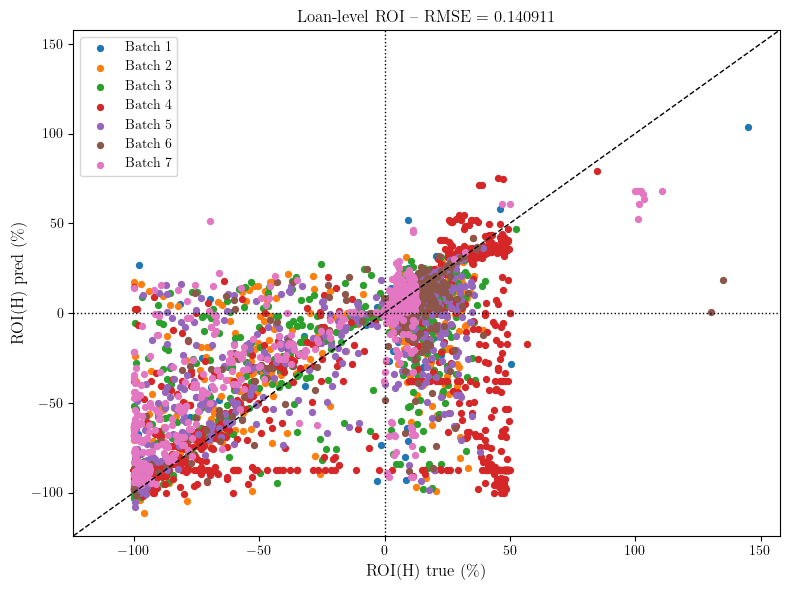

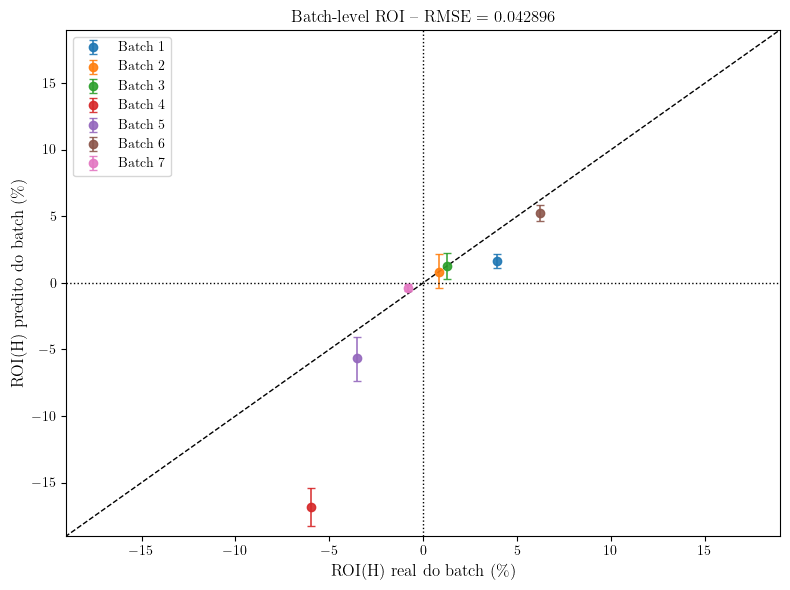

In [7]:
scenario2_plots_roi(scenario2_snap_roi, scenario2_truth_can, scenario2_metrics_roi)

Now we move on to test our second model. The same metrics as before are shown again for this model, for its prediction of net cash and ROI in either loan level or batch level.

In [8]:
scenario2_snap_cash = scenario2_snap_cash_func(loan_CF, H = 730, t = 200)
scenario2_snap_cash, reg_, test_idx_cash = scenario2_data_split_model_train_cash(scenario2_snap_cash, RNG = 42)
scenario2_eval_b_net, scenario2_eval_b_roi, scenario2_metrics_cash = scenario2_compute_metrics_cash(loan_CF, scenario2_snap_cash, test_idx_cash, H = 730)

[Loan-level | NET_CASH(H)] RMSE=305.589362 | MAE=56.343602
[Loan-level | ROI(H)] RMSE=0.135456 | MAE=0.039910 | SignACC=0.893 | BACC=0.733
--------------------------------------------------
[Batch-level | NET_CASH(H)] RMSE=268257.919059 | MAE=208405.985288
[Batch-level | ROI(H)]  RMSE=0.030642 | MAE=0.018872 | SignACC=1.000 | BACC=1.000


This time I show you three different plots. 

The first one is a plot of net cash on loan level. Here we compare the model predictions with the real data. 
Next we convert the net cash predictions of the model into $ROI_X(H)$ for each loan, and compare it to the true value.
Then we move on to the batch level, and I show you first the batch net cash prediction vs true data. In the next plot we finnaly compute the expected batch $ROI(H)$ and compare it with the real data. We also compute the $95\%$ CI for each batch prediction.

You can see that in this scenario the model is not capable of predicting the net cash of the batches (see third figure). Of course this is the case. While the model can predict the net cash on individual loans quite well, when it comes to the batch it cannot. This can be very easily explained if we remember that in this scenario, to compute the batch $ROI_b(H)$ and net cash, we are considering the loans taking place between the decision time $t$ and the horizon $H$. Since the batch net cash is dependent on both the amount of money paid on each loan and the loan amount, the inflow and outflow of cash in the period $t<T<H$ will drastically influence this quantity.

Why then the results for $ROI_b(H)$ in the last plot are not completely terrible in this scenario. The ROI is a much more stable measurement of the loan or batch return (see EDA notebook plots). The ROI also takes much longer to be affected by single loans withdraws or payments. Therefore, while the loans taking place between t and H still affect $ROI_b(H)$, we can still get a reasonable guess to this quantity from our model.

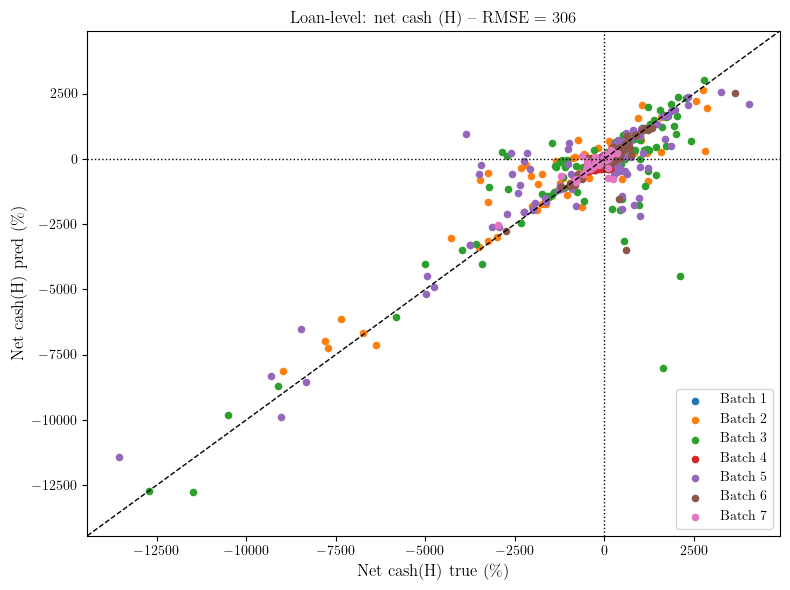

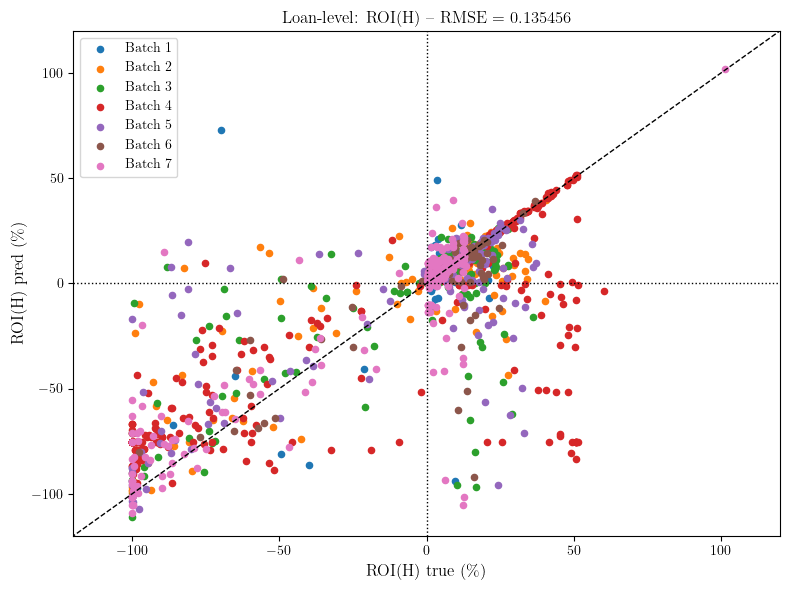

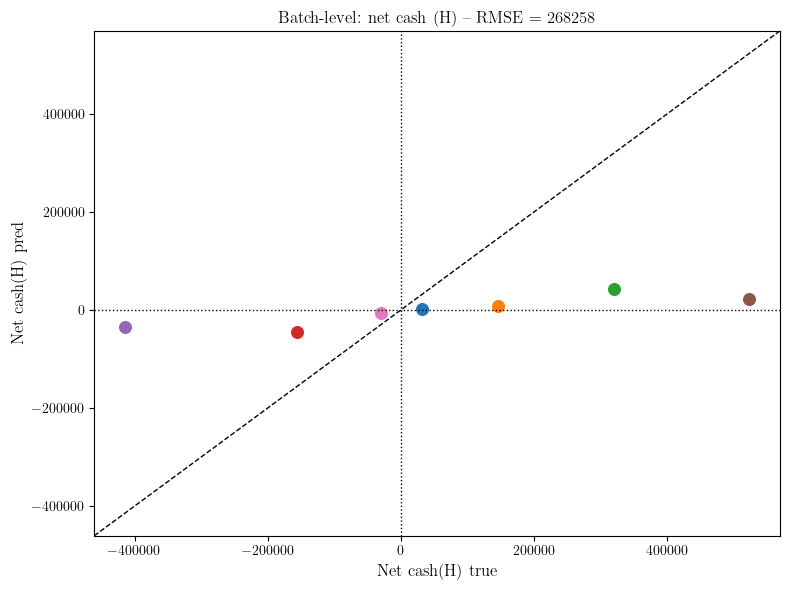

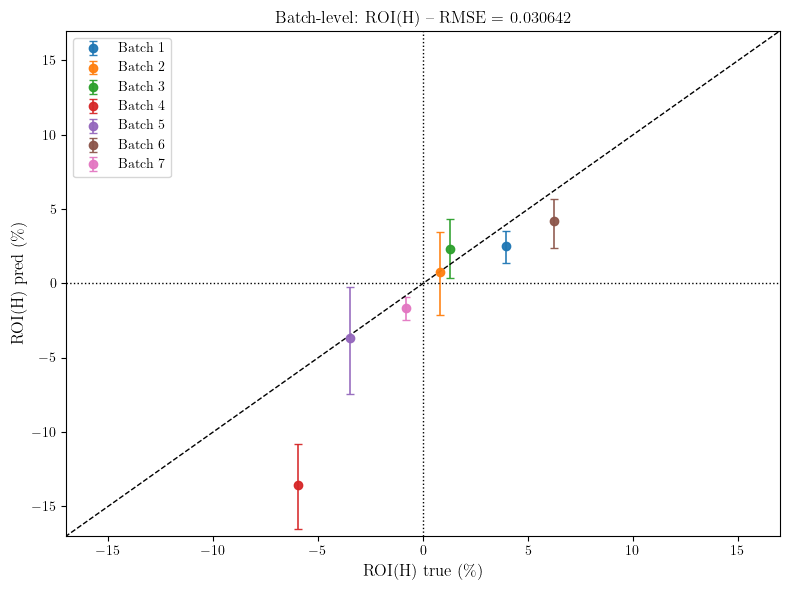

In [9]:
scenario2_plots_cash(scenario2_snap_cash, scenario2_eval_b_net, scenario2_eval_b_roi, scenario2_metrics_cash, test_idx_cash, savefig = True, RNG = 42)

---

### P90 filtered dataframe

Starting here we train our models again, but this time removing the uper 90% percentile largest outlier loans from our dataframes.

As you can observe, the wrong guess to the batch net cash continues to ocurr

In [10]:
loan_CF_filtered, removal_summary, batch_thresholds = remove_top_loans_per_batch(loan_CF,p=0.90)

In [11]:
scenario2_snap_roi_filtered = scenario2_snap_roi_func(loan_CF_filtered, H = 730, t = 200)
scenario2_snap_roi_filtered, reg_ = scenario2_data_split_model_train_roi(scenario2_snap_roi_filtered, RNG = 42)
scenario2_mask_pred_roi_filtered, scenario2_truth_can_filtered, scenario2_metrics_roi_filtered = scenario2_compute_metrics_roi(scenario2_snap_roi_filtered, loan_CF_filtered, H = 730)

[Loan-level | ROI(H)] RMSE=0.141296 | MAE=0.035584 | SignACC=0.901 | BACC=0.749
--------------------------------------------------
[Batch-level | ROI(H)] RMSE=0.038707 | MAE=0.023803 | SignACC=1.000 | BACC=1.000


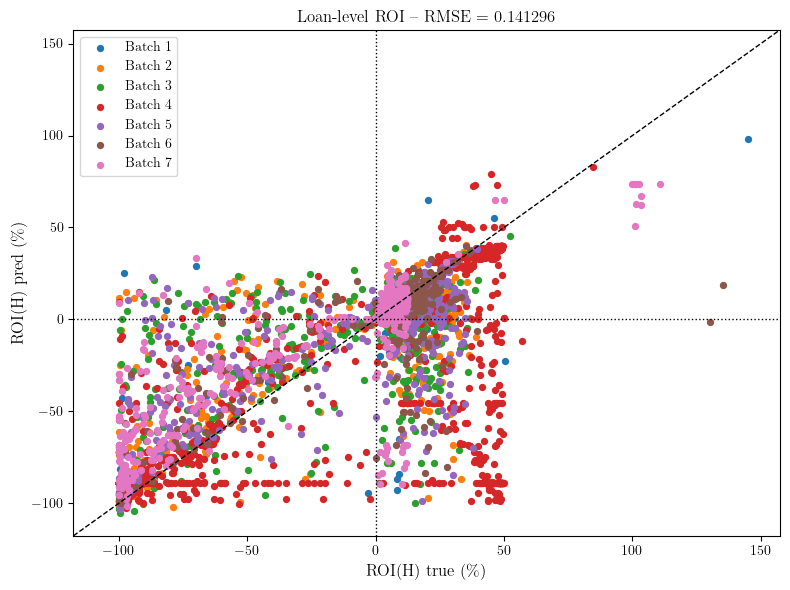

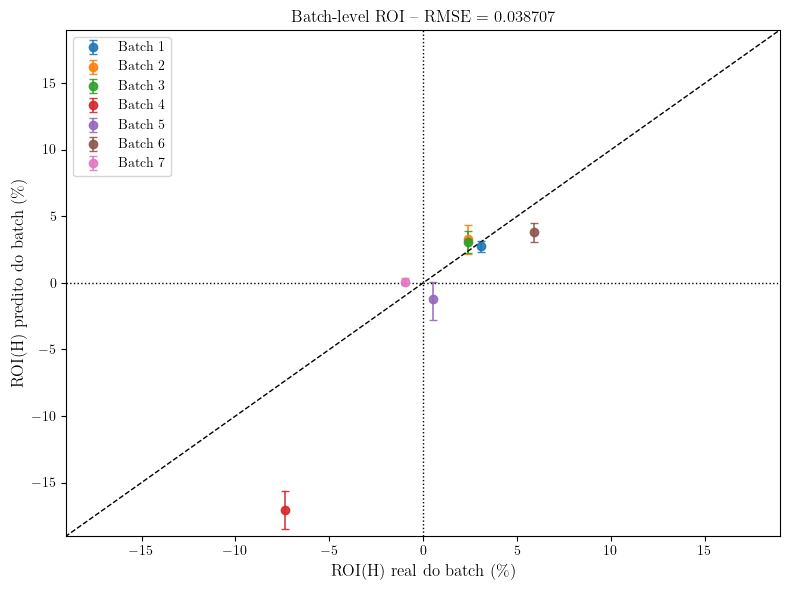

In [12]:
scenario2_plots_roi(scenario2_snap_roi_filtered, scenario2_truth_can_filtered, scenario2_metrics_roi_filtered, filtered = 'p90')

In [13]:
scenario2_snap_cash_filtered = scenario2_snap_cash_func(loan_CF_filtered, H = 730, t = 200)
scenario2_snap_cash_filtered, reg_, test_idx_cash_filtered = scenario2_data_split_model_train_cash(scenario2_snap_cash_filtered, RNG = 42)
scenario2_eval_b_net_filtered, scenario2_eval_b_roi_filtered, scenario2_metrics_cash_filtered = scenario2_compute_metrics_cash(loan_CF_filtered, scenario2_snap_cash_filtered, test_idx_cash_filtered, H = 730)

[Loan-level | NET_CASH(H)] RMSE=256.693946 | MAE=45.761291
[Loan-level | ROI(H)] RMSE=0.136035 | MAE=0.039177 | SignACC=0.896 | BACC=0.740
--------------------------------------------------
[Batch-level | NET_CASH(H)] RMSE=208941.656785 | MAE=159829.787567
[Batch-level | ROI(H)]  RMSE=0.027447 | MAE=0.021381 | SignACC=1.000 | BACC=1.000


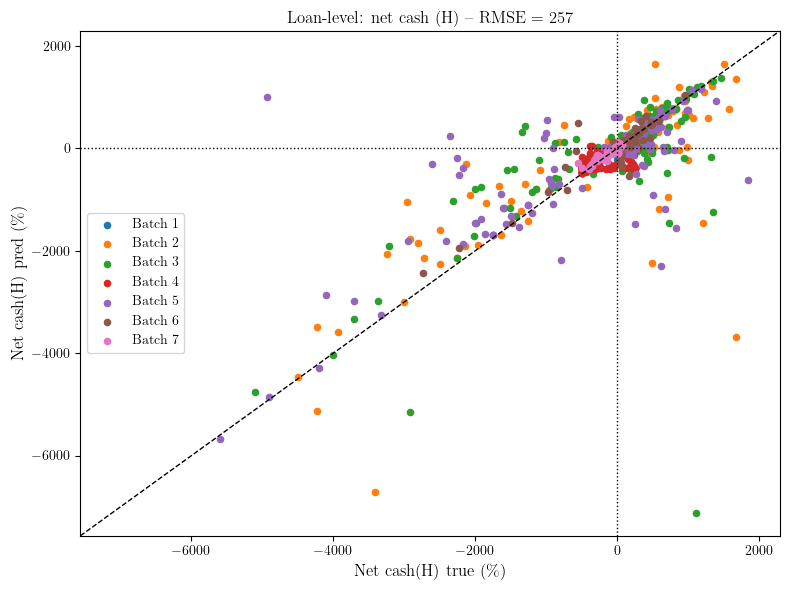

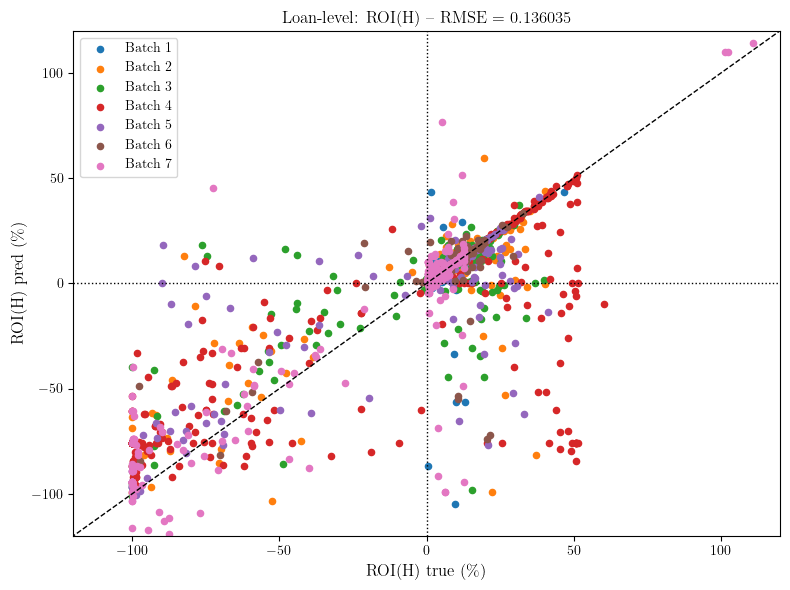

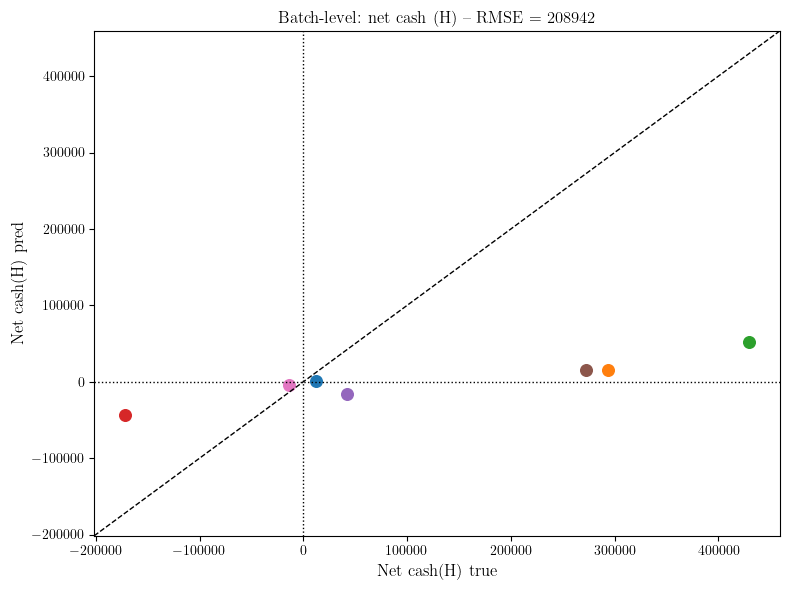

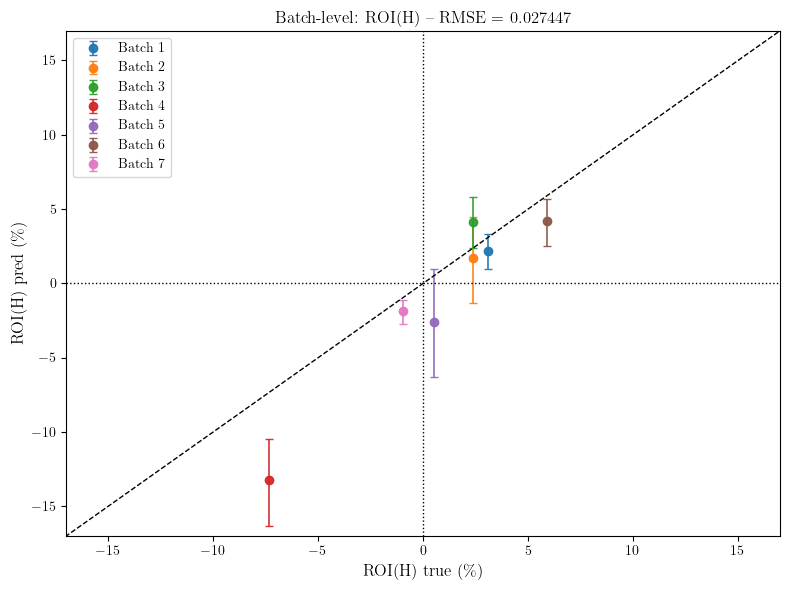

In [14]:
scenario2_plots_cash(scenario2_snap_cash_filtered, scenario2_eval_b_net_filtered, scenario2_eval_b_roi_filtered, scenario2_metrics_cash_filtered, test_idx_cash_filtered, filtered = 'p90', savefig = True, RNG = 42)

---

### Model comparison

It is finnaly time to compare our four models in Scenario 1

In [15]:
all_metrics = [
    scenario2_metrics_roi,
    scenario2_metrics_cash,
    scenario2_metrics_roi_filtered,
    scenario2_metrics_cash_filtered
    ]

Model_n = [
    'Scenario 2: model 1',
    'Scenario 2: model 2',
    'Scenario 2: model 1 + p90 filter',
    'Scenario 2: model 2 + p90 filter'
    ]

In [16]:
metrics = [metric['comp_metric'] for metric in all_metrics]

### Our best model in this scenario is Model 2 (predicts net cash) with our filtered dataset!!


However, I would personally stick with Model 1 if Scenario 1 is chosen to be used in analysis like this.

In [17]:
print('BEST MODEL:')
print('------------>' + Model_n[np.argmin(metrics)])

BEST MODEL:
------------>Scenario 2: model 2 + p90 filter
